In [75]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sahu-rai-abcd/train.csv
/kaggle/input/sahu-rai-abcd/test.csv


In [76]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)

In [77]:
test=pd.read_csv('/kaggle/input/sahu-rai-abcd/test.csv')
train=pd.read_csv('/kaggle/input/sahu-rai-abcd/train.csv')

In [78]:
print(train.head())
print(train.shape)
print(test.shape)
print(train.info)

   Gender        Age    Height      Weight family_history_with_overweight  \
0    Male  33.226808  1.766888   83.337721                            yes   
1  Female  18.000000  1.600000   55.000000                            yes   
2     NaN  26.000000  1.640741  111.930700                            yes   
3    Male  19.000000  1.690000   64.000000                             no   
4    Male        NaN  1.606474   94.189167                            yes   

  FAVC  FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  TUE  \
0  NaN   2.0       NaN   Sometimes    no  1.964435  no  0.750111  0.0   
1  yes   2.0  3.000000   Sometimes    no  2.000000  no  1.000000  1.0   
2  yes   3.0  3.000000   Sometimes    no  2.617988  no  0.000000  NaN   
3  yes   2.0       NaN  Frequently    no  2.000000  no  0.000000  1.0   
4  yes   2.0  2.812283   Sometimes    no  2.000000  no  1.000000  0.0   

        CALC                 MTRANS           NObeyesdad  
0         no             Automobile  Ov

In [79]:
test_id = None
if "id" in test.columns:
    test_id = test["id"]
    test = test.drop(columns=["id"])


In [80]:
def detect_target(train_df, test_df):
    for col in train_df.columns:
        if col not in test_df.columns:
            return col

target = detect_target(train, test)
print("Target column:", target)


Target column: NObeyesdad


In [81]:
train.isnull().sum()

Gender                            1235
Age                               1811
Height                            1604
Weight                            1468
family_history_with_overweight    1065
FAVC                              1049
FCVC                               975
NCP                               1720
CAEC                              1465
SMOKE                             1547
CH2O                               933
SCC                               1803
FAF                               1724
TUE                               1120
CALC                              1090
MTRANS                            1089
NObeyesdad                           0
dtype: int64

In [82]:
# 1. Calculate NaN percentages on the training set
nan_series = (train.isnull().sum() / len(train)) * 100

# 2. Set your threshold (14% is a good starting point for your data)
threshold = 14
cols_to_drop = nan_series[nan_series > threshold].index.tolist()

# 3. SAFETY CHECK: Never drop your target or ID columns automatically
protected_cols = [target]
cols_to_drop = [c for c in cols_to_drop if c not in protected_cols]

# 4. Drop from BOTH datasets
train_cleaned = train.drop(columns=cols_to_drop)
train_cleaned = train_cleaned.dropna(subset=[target]).reset_index(drop=True)
test_cleaned = test.drop(columns=cols_to_drop)

print(f"Columns dropped: {cols_to_drop}")
print(f"Remaining features of test column: {test_cleaned.columns.tolist()}")
print(f"Remaining features of train column: {train_cleaned.columns.tolist()}")

Columns dropped: []
Remaining features of test column: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
Remaining features of train column: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']


In [83]:
X = train_cleaned.drop(columns=[target])
y = train_cleaned[target]

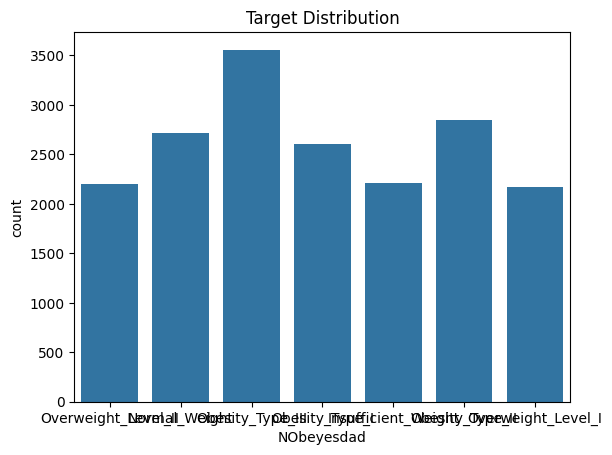

In [84]:
sns.countplot(x=y)
plt.title("Target Distribution")
plt.show()

In [85]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=np.number).columns

print("Categorical columns:", list(cat_cols))
print("Numerical columns:", list(num_cols))

Categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
Numerical columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


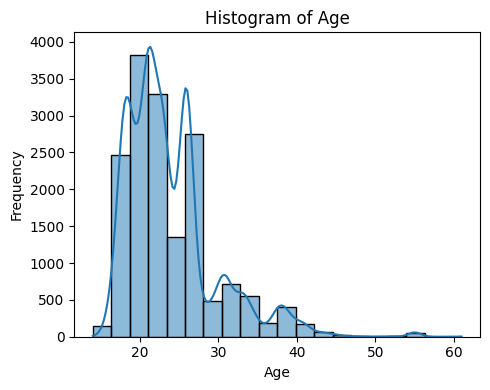

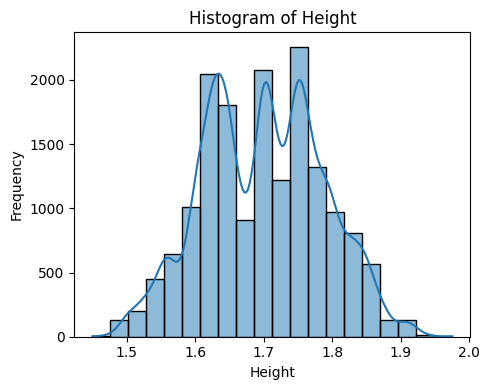

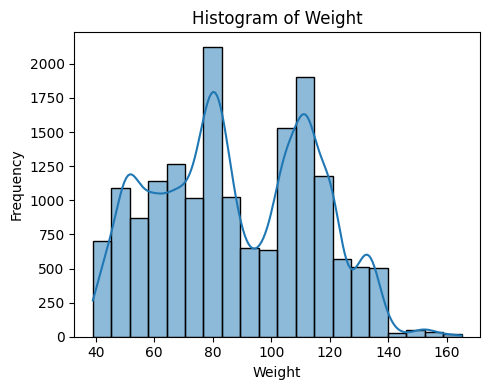

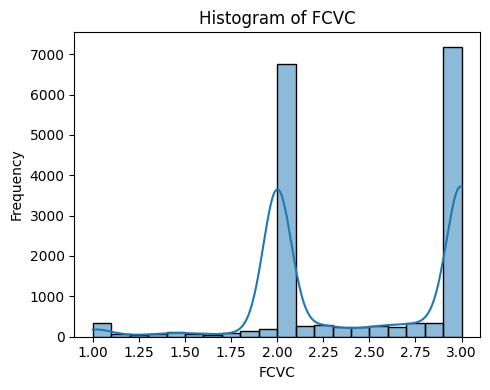

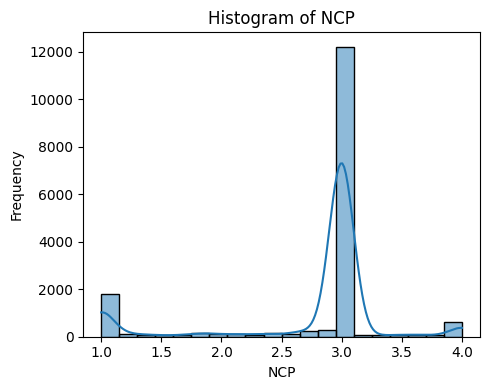

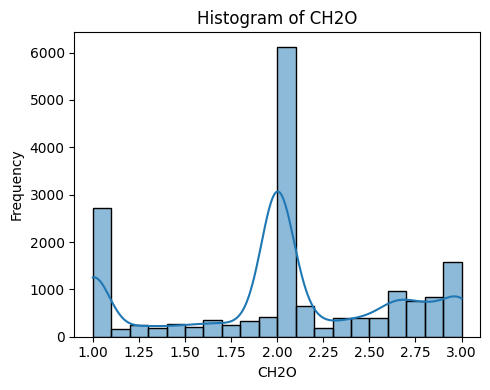

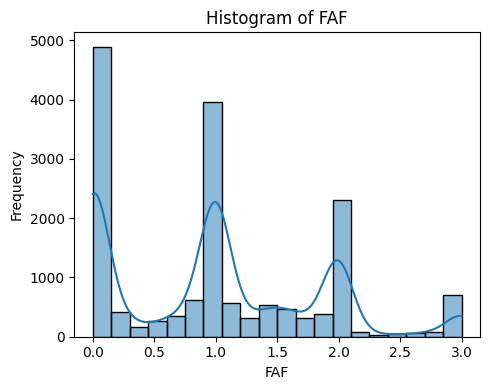

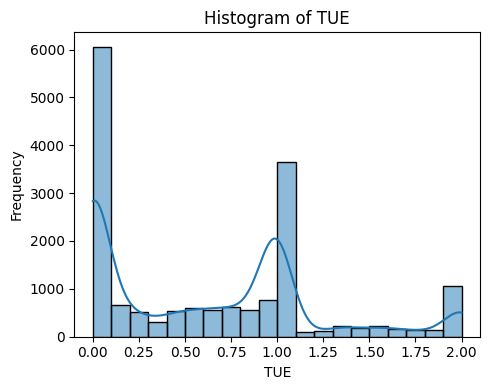

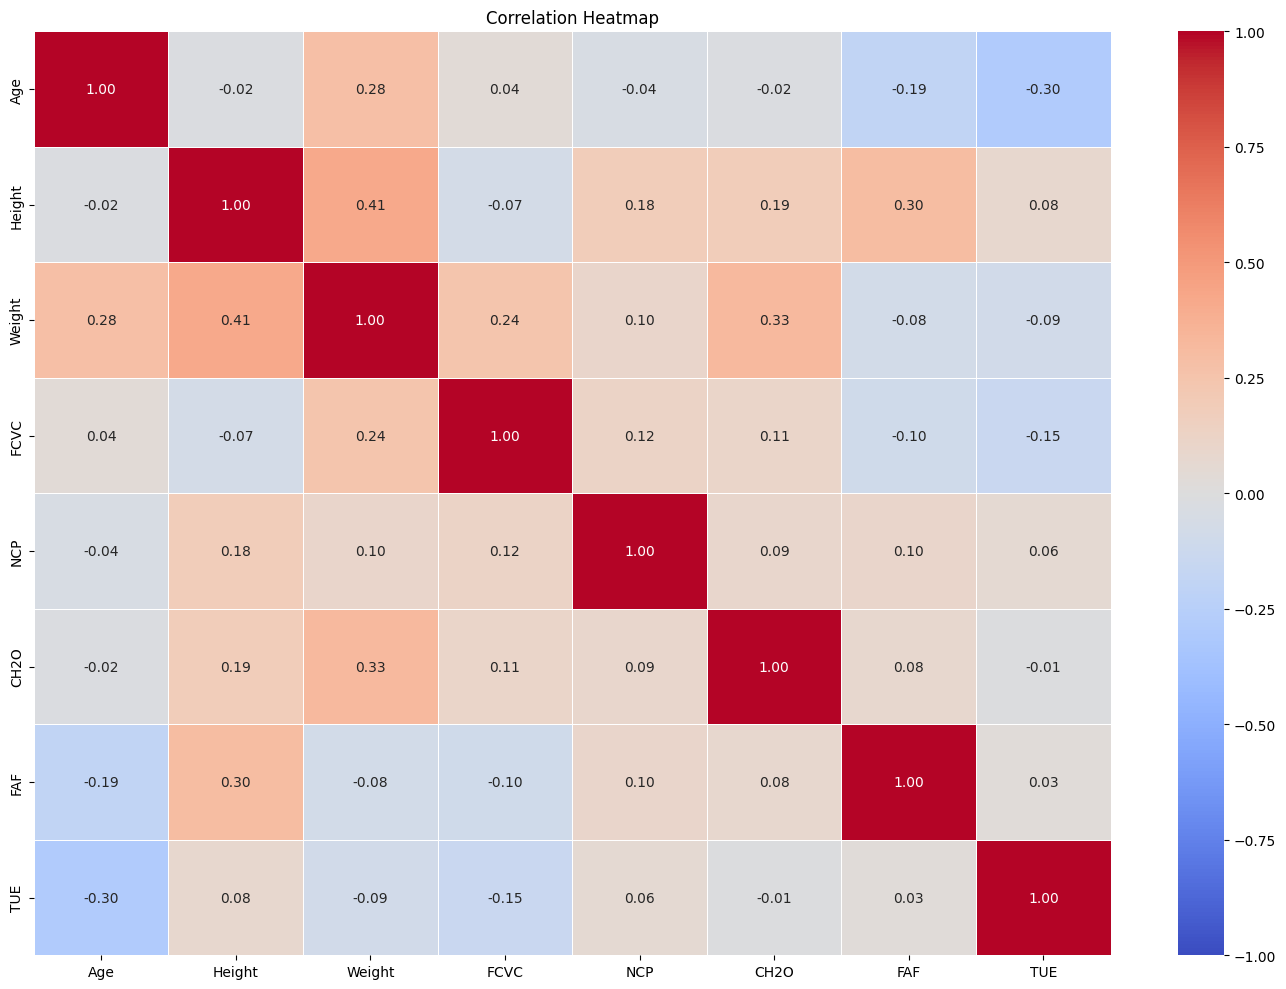

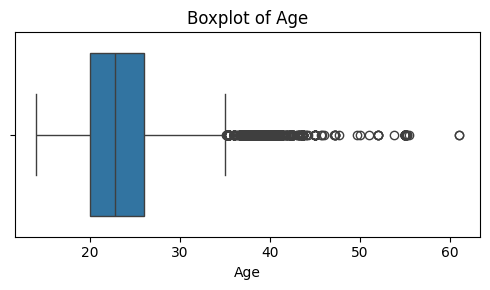

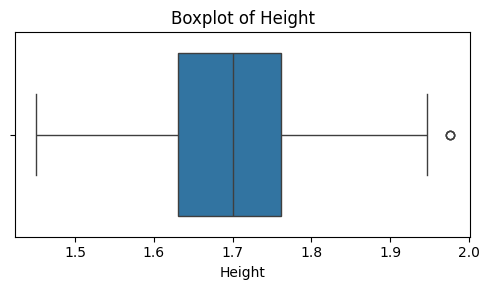

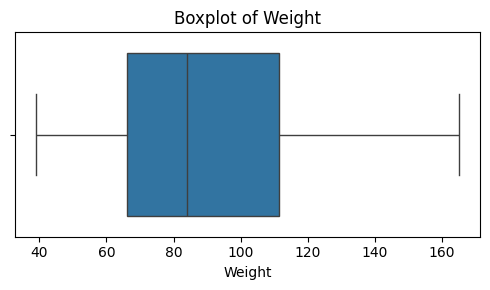

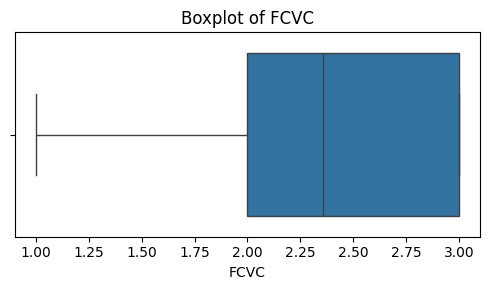

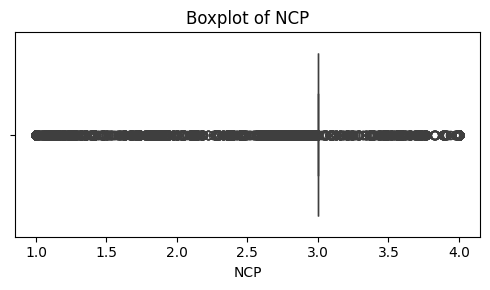

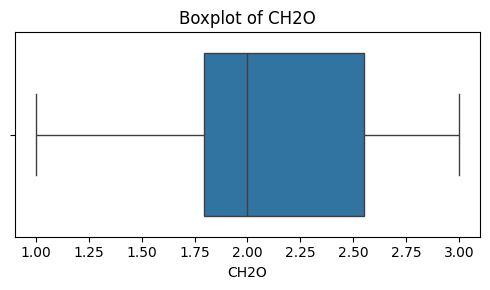

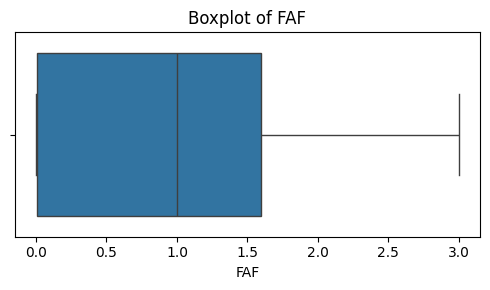

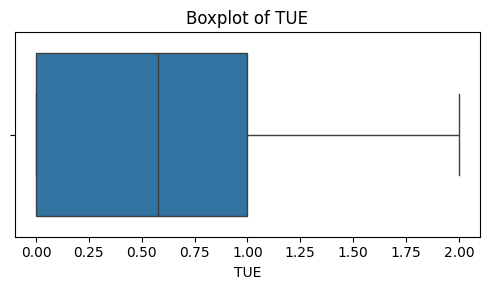

In [86]:
# ===================== HISTOGRAMS =====================
for col in num_cols:
    plt.figure(figsize=(5, 4))
    sns.histplot(train[col], bins=20, kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


# ===================== CORRELATION HEATMAP =====================
plt.figure(figsize=(14, 10))
sns.heatmap(
    train[num_cols].corr(),
    cmap="coolwarm",
    annot=True,          # show values
    fmt=".2f",           # 2 decimal places
    linewidths=0.5,
    vmin=-1, vmax=1      # full correlation scale
)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()



# ===================== BOXPLOTS =====================
for col in num_cols:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=train[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


In [87]:
#handling missing values
for col in cat_cols:
    mod = X[col].mode()[0];
    X[col] = X[col].fillna(mod)
    test_cleaned[col] = test_cleaned[col].fillna(mod)

for col in num_cols:
    med = X[col].median()
    X[col] = X[col].fillna(med)
    test_cleaned[col] = test_cleaned[col].fillna(med)


In [88]:
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

    test_cleaned[col] = test_cleaned[col].astype(str)
    test_cleaned[col] =test_cleaned[col].apply(lambda x: x if x in le.classes_ else "Missing")

    if "Missing" not in le.classes_:
        le.classes_ = np.append(le.classes_, "Missing")

    test_cleaned[col] = le.transform(test[col])

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

In [89]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [90]:
if len(num_cols) > 0:
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_val[num_cols] = scaler.transform(X_val[num_cols])
    test_cleaned[num_cols] = scaler.transform(test_cleaned[num_cols])


In [91]:
param_dist = {
    "n_estimators": [50,80,100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

rf = RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)
print("Best RF Parameters:", rf_random.best_params_)

Best RF Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': False}


In [92]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB()
}


Model: Logistic Regression
Accuracy: 0.7610595303113052
Precision: 0.7583012868819591
Recall: 0.7610595303113052
F1: 0.7589193695165762


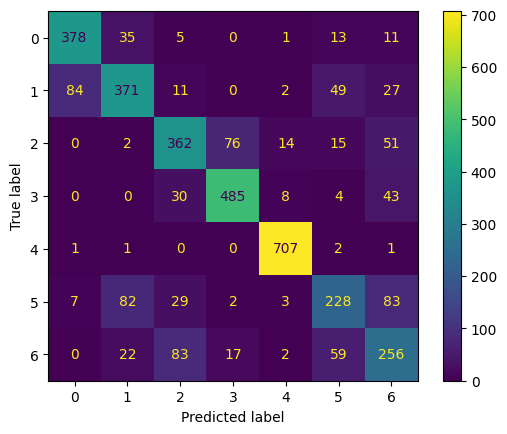


Model: KNN
Accuracy: 0.7381212452211906
Precision: 0.7327628326343695
Recall: 0.7381212452211906
F1: 0.7335802947232295


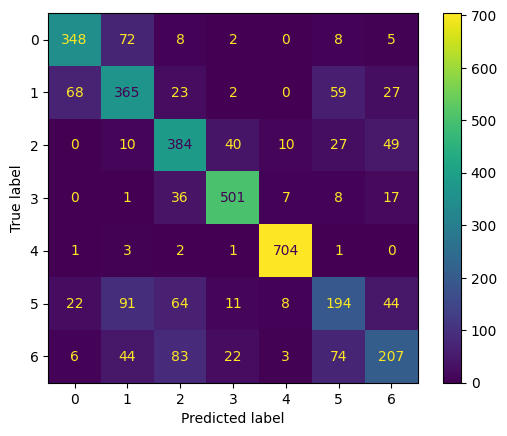


Model: Decision Tree
Accuracy: 0.8339705079191698
Precision: 0.8363307925781568
Recall: 0.8339705079191698
F1: 0.8346553316605398


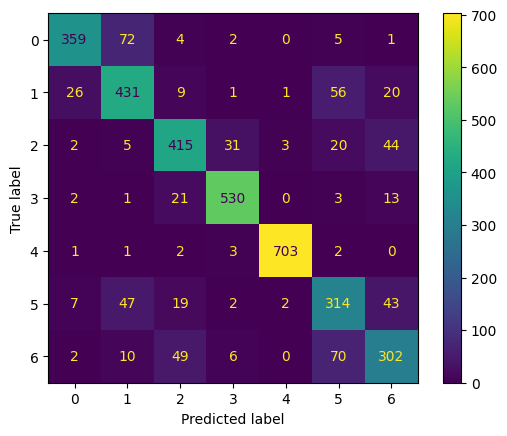


Model: Random Forest
Accuracy: 0.886400873839432
Precision: 0.8869751195675558
Recall: 0.886400873839432
F1: 0.8865020830534115


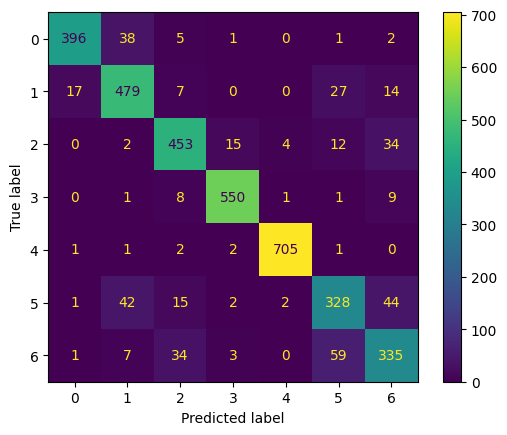


Model: Gradient Boosting
Accuracy: 0.877389404696887
Precision: 0.8780845503993231
Recall: 0.877389404696887
F1: 0.8775760836675555


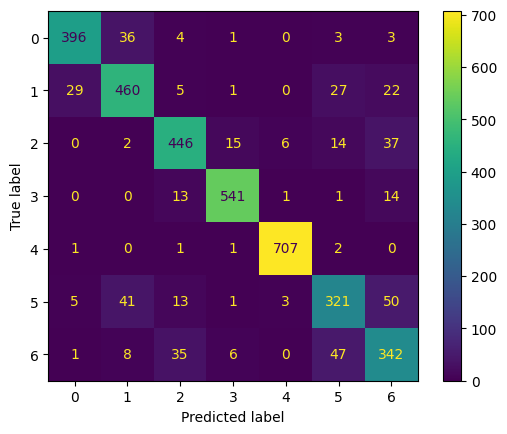


Model: SVM
Accuracy: 0.8140360458765702
Precision: 0.8145612956143119
Recall: 0.8140360458765702
F1: 0.8135843001914889


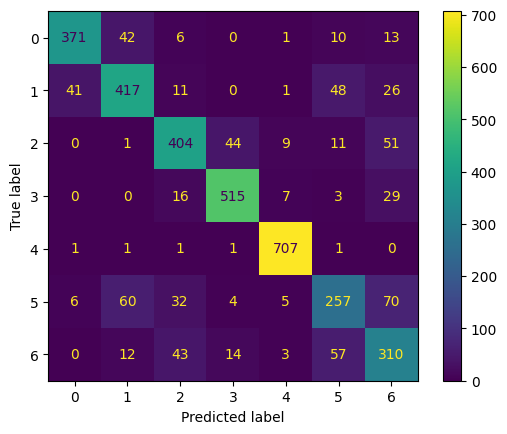


Model: Naive Bayes
Accuracy: 0.6018569087930092
Precision: 0.591374954049567
Recall: 0.6018569087930092
F1: 0.5645003280674287


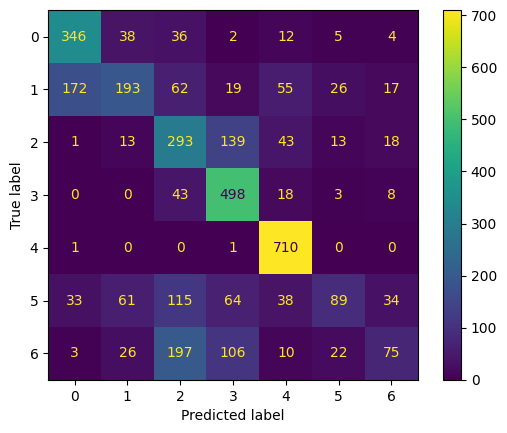

In [93]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    print("\nModel:", name)
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("Precision:", precision_score(y_val, y_pred, average='weighted'))
    print("Recall:", recall_score(y_val, y_pred, average='weighted'))
    print("F1:", f1_score(y_val, y_pred, average='weighted'))

    ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
    plt.show()

In [94]:
final_model = RandomForestClassifier(n_estimators=300, random_state=42)
final_model.fit(X, y)


RandomForestClassifier(n_estimators=300, random_state=42)

In [95]:
test_final = test_cleaned[X.columns]

In [96]:
test_pred = final_model.predict(test_final)
test_pred = target_encoder.inverse_transform(test_pred)

In [101]:
submission = pd.DataFrame({
    "id": test_id if test_id is not None else range(len(test_pred)),
    target: test_pred
})

submission.to_csv("final_submission.csv", index=False)
print("Submission created!")


Submission created!


In [99]:


# # 1. Get probabilities instead of single labels
# # final_probs will have one column for every class (e.g., Obesity Type I, Normal, etc.)
# final_probs = final_model.predict_proba(test_final)

# # 2. Use target_encoder to get the correct class names
# # Important: Do NOT use 'le.classes_', use 'target_encoder.classes_'
# class_names = target_encoder.classes_

# # 3. Create DataFrame with ID and probabilities
# submission_probs = pd.DataFrame(final_probs, columns=class_names)

# # Ensure the ID column is added at the start
# submission_probs.insert(0, 'id', test_id)

# # 4. Save
# submission_probs.to_csv("submission_probabilities.csv", index=False)
# print("Multi-class probability submission saved successfully!")
# print(submission_probs.head())

Multi-class probability submission saved successfully!
   id  Insufficient_Weight  Normal_Weight  Obesity_Type_I  Obesity_Type_II  \
0   1             0.516667       0.263333        0.030000         0.000000   
1   2             0.493333       0.250000        0.003333         0.000000   
2   3             0.473333       0.290000        0.030000         0.000000   
3   4             0.386667       0.363333        0.046667         0.003333   
4   5             0.526667       0.273333        0.000000         0.003333   

   Obesity_Type_III  Overweight_Level_I  Overweight_Level_II  
0               0.0            0.156667             0.033333  
1               0.0            0.250000             0.003333  
2               0.0            0.110000             0.096667  
3               0.0            0.163333             0.036667  
4               0.0            0.176667             0.020000  


In [ ]:
# # 1. Get probabilities
# final_probs = final_model.predict_proba(test_final)

# # 2. Get the original class names (e.g., ['C', 'D', 'CL'])
# original_classes = target_encoder.classes_

# # 3. Add the "Status_" prefix to each class name
# # This turns 'C' into 'Status_C', 'D' into 'Status_D', etc.
# fixed_column_names = [f"Status_{name}" for name in original_classes]

# # 4. Create the DataFrame with fixed names
# submission_probs = pd.DataFrame(final_probs, columns=fixed_column_names)

# # 5. Insert ID and Save
# submission_probs.insert(0, 'id', test_id)
# submission_probs.to_csv("submission_probabilities.csv", index=False)

# print("Fixed column names:", fixed_column_names)
# print(submission_probs.head())